<img src=https://audiovisuales.icesi.edu.co/assets/custom/images/ICESI_logo_prin_descriptor_RGB_POSITIVO_0924.jpg width=200>

  ### Maestría en Inteligencia Artificial
  ### Proyecto de Innovación

## **1. Carga de paquetes**

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            precision_score, recall_score, f1_score, roc_curve, auc)
from tensorflow.keras.metrics import AUC, Precision, Recall

## **2. Carga de datos**

Se espera encontrar las imágenes en la carpeta base, conteniendo las diferentes bases de datos de imágenes en una carpeta cada una: ORIGA, REFUGE y G1020.

Si los datos se encuentran en Google Drive / Google Colab (descomentar las siguientes líneas):

In [106]:
# # Montar Drive
# Si estás usando Google Colab, descomenta las siguientes líneas para montar tu Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Rutas base
# base_path = "/content/drive/MyDrive/Colab Notebooks/Glaucoma"

Si los datos se encuentran en local (descomentar la línea siguiente):

In [2]:
df_origa = pd.read_csv('ORIGA/origa_info.csv')
df_g1020 = pd.read_csv('G1020/G1020.csv')
df_refuge_train = pd.read_json('REFUGE/train/index.json', orient='index')
df_refuge_test = pd.read_json('REFUGE/test/index.json', orient='index') ## esta no tiene label

In [3]:
#Identifico la base
df_origa['Source'] = 'ORIGA'
df_g1020['Source'] = 'G1020'
df_refuge_train['Source'] = 'REFUGE'

#Renombro columnas
df_g1020 = df_g1020.rename(columns={'imageID': 'Image','binaryLabels': 'Glaucoma'})
df_refuge_train = df_refuge_train.rename(columns={'ImgName': 'Image','Label': 'Glaucoma'})

#Uno las bases
df_glaucoma = pd.concat([df_origa[['Source', 'Image', 'Glaucoma']],
                      df_g1020[['Source', 'Image', 'Glaucoma']],
                      df_refuge_train[['Source', 'Image', 'Glaucoma']]], ignore_index=True)

In [14]:
# Rutas diferentes para cada base de datos
root_origa = "ORIGA\Images_Cropped"
root_g1020 = "G1020\Images_Cropped"
root_refuge = "REFUGE\\train\Images_Cropped"


# Función para aplicar la ruta correcta
def get_image_path(row):
    if row['Source'] == 'ORIGA':
        return os.path.join(root_origa, row['Image'])
    elif row['Source'] == 'G1020':
        return os.path.join(root_g1020, row['Image'])
    elif row['Source'] == 'REFUGE':
        return os.path.join(root_refuge, row['Image'])
    else:
        return None  # En caso de que no coincida con ninguna base

# Aplicar la función a cada fila para crear la columna 'Path'
df_glaucoma['Path'] = df_glaucoma.apply(get_image_path, axis=1)

# Unifico con la base de la U
df_glaucoma = pd.concat([df_glaucoma[['Source','Path', 'Image', 'Glaucoma']]], ignore_index=True)

df_glaucoma['Glaucoma'] = df_glaucoma['Glaucoma'].astype("str")

# Verificar los resultados
df_glaucoma

,Source,Path,Image,Glaucoma
0,ORIGA,ORIGA\Images_Cropped\001.jpg,001.jpg,0
1,ORIGA,ORIGA\Images_Cropped\002.jpg,002.jpg,0
2,ORIGA,ORIGA\Images_Cropped\003.jpg,003.jpg,0
3,ORIGA,ORIGA\Images_Cropped\004.jpg,004.jpg,0
4,ORIGA,ORIGA\Images_Cropped\005.jpg,005.jpg,0
...,...,...,...,...
2065,REFUGE,REFUGE\train\Images_Cropped\n0356.jpg,n0356.jpg,0
2066,REFUGE,REFUGE\train\Images_Cropped\n0357.jpg,n0357.jpg,0
2067,REFUGE,REFUGE\train\Images_Cropped\n0358.jpg,n0358.jpg,0
2068,REFUGE,REFUGE\train\Images_Cropped\n0359.jpg,n0359.jpg,0


In [15]:
conteo = df_glaucoma.groupby('Source').size().reset_index(name='Cantidad')
print(conteo)

   Source  Cantidad
0   G1020      1020
1   ORIGA       650
2  REFUGE       400


Partimos train y test

In [16]:
df_train, df_test = train_test_split(df_glaucoma, test_size=0.15, random_state=42, stratify=df_glaucoma['Glaucoma'])

In [17]:
print("Distribucion en entrenamiento:")
print(df_train['Glaucoma'].value_counts(normalize=True))

print("Distribucion en test:")
print(df_test['Glaucoma'].value_counts(normalize=True))

Distribucion en entrenamiento:
Glaucoma
0    0.75668
1    0.24332
Name: proportion, dtype: float64
Distribucion en test:
Glaucoma
0    0.755627
1    0.244373
Name: proportion, dtype: float64


## **3. Parametros para el modelamiento**


Configuración de parámetros para DA y VGG16

In [18]:
width_shape = 224
height_shape = 224
num_classes = 2
epochs = 15
batch_size = 8

Aplicamos técnica de Data Augmentation con el fin de obtener más muestras y que el modelo no presente overfitting.
Acá se puede ver cómo se generan diferentes imágenes a partir de una sola, aplicando modificaciones en este caso como rotación, giros horizontales y verticales.


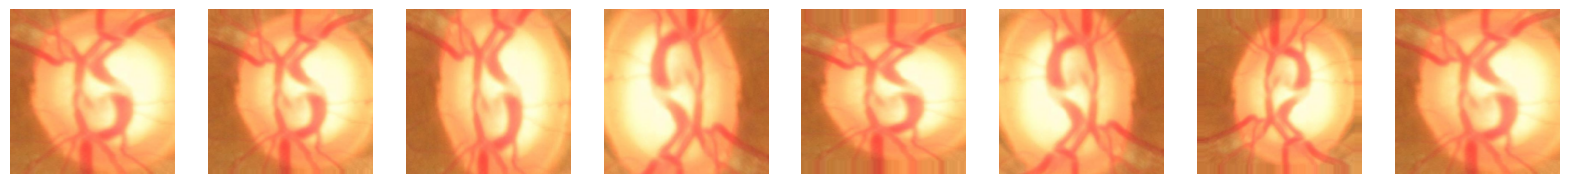

In [19]:
ruta_imagen = df_glaucoma['Path'].iloc[0]

# Cargar imagen, convertir a array y expandir dimensiones para simular batch
img = load_img(ruta_imagen, target_size=(width_shape, height_shape))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)  # shape (1, 224, 224, 3)

# Generador de visualización
vis_datagen = ImageDataGenerator(
    # rotation_range=90,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Mostrar imágenes aumentadas
plt.figure(figsize=(20,4))
i = 0
for batch in vis_datagen.flow(x, batch_size=1):
    plt.subplot(1, 8, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    i += 1
    if i >= 8:
        break
plt.show()

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import pandas as pd

# Parámetros
path_destino = 'Images_Augmentation'
n_aug = 2
width_shape = 224
height_shape = 224

# Crear carpeta destino si no existe
os.makedirs(path_destino, exist_ok=True)

# Eliminar contenido previo sin borrar carpeta
for root, dirs, files in os.walk(path_destino):
    for file in files:
        try:
            os.remove(os.path.join(root, file))
        except PermissionError:
            print(f"No se pudo borrar: {file}. Puede estar en uso.")

# Filtrar solo clase 1
df_clase_1 = df_train[df_train['Glaucoma'] == '1']

# Configurar aumentos
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)

# Lista para nuevas filas
nuevas_filas = []

# Generar imágenes aumentadas
for _, row in df_clase_1.iterrows():
    path_original = row['Path']
    clase = row['Glaucoma']
    nombre_base = os.path.splitext(os.path.basename(path_original))[0]

    try:
        img = load_img(path_original, target_size=(width_shape, height_shape))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        i = 0
        for batch in datagen.flow(
            x,
            batch_size=1,
            save_to_dir=path_destino,
            save_prefix=f"{nombre_base}_aug",
            save_format='jpg'
        ):
            nueva_path = os.path.join(path_destino, f"{nombre_base}_aug_{i}.jpg")
            nuevas_filas.append({'Path': nueva_path, 'Glaucoma': clase})
            i += 1
            if i >= n_aug:
                break

    except FileNotFoundError:
        print(f"No se encontró la imagen: {path_original}")
    except Exception as e:
        print(f"Error procesando {path_original}: {e}")

# Crear DataFrame con aumentadas y unirlo
df_aug = pd.DataFrame(nuevas_filas)
df_train = pd.concat([df_train, df_aug], ignore_index=True)


Generador de imágenes (entrenamiento y test)

In [21]:
train_datagen = ImageDataGenerator(
    # rotation_range=90,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='Path',
    y_col='Glaucoma',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='Path',
    y_col='Glaucoma',
    target_size=(width_shape, height_shape),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

n_train = train_generator.samples
n_test = test_generator.samples

Found 1759 validated image filenames belonging to 2 classes.
Found 311 validated image filenames belonging to 2 classes.


c:\Users\sebas\OneDrive - Universidad Icesi\venv\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 856 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  warnings.warn(


Se identificó un problema de desbalanceo de clases, es decir, un mayor número de observaciones negativas que positivas lo cual afectaría al entrenamiento, por lo que se calcularon los pesos respectivos para cada clase, de tal forma, que se le da más prioridad al momento en el entrenamiento a la clase minoritaria.

In [22]:
classes = np.unique(df_train['Glaucoma'])

# Calcular pesos automáticos
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=df_train['Glaucoma']
)

# Convertir a diccionario
class_weights = dict(zip(classes, class_weights))

print("Pesos por clase:", class_weights)

Pesos por clase: {'0': 0.982344102178813, '1': 1.0183021806853583}


In [23]:
print("Distribucion en entrenamiento:")
print(df_train['Glaucoma'].value_counts(normalize=True))

Distribucion en entrenamiento:
Glaucoma
0    0.508987
1    0.491013
Name: proportion, dtype: float64


## **4. Entrenamiento de modelo VGG16**

Configuración del modelo personalizando las capas de salida para ajustarlo a nuestro problema de clasificación binaria.

In [24]:
# Número de muestras
nb_train_samples = n_train
nb_validation_samples = n_test

# Cargar la base de VGG16 sin las capas superiores
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(width_shape, height_shape, 3))

# Congelar las capas de la base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas personalizadas para la clasificación
x = base_model.output
x = Flatten()(x)
predicciones = Dense(1, activation='sigmoid')(x)

# Definir el modelo completo
vgg16_model = Model(inputs=base_model.input, outputs=predicciones)

# Compilar el modelo
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001),
               loss='binary_crossentropy',
               metrics=['binary_accuracy',AUC(),Precision(), Recall()])
vgg16_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

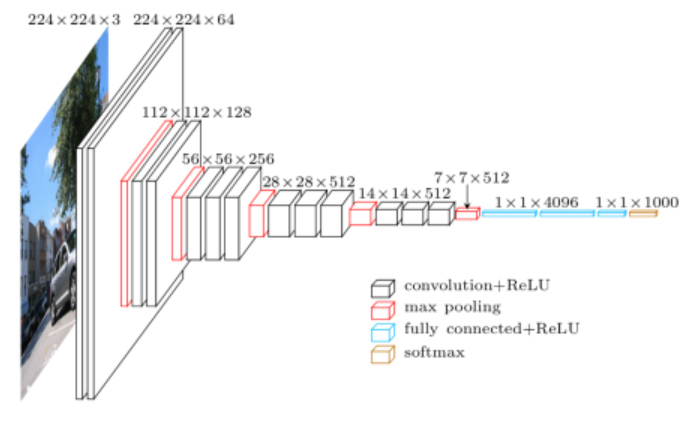

In [25]:
# Entrenamiento del modelo
model_history = vgg16_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_steps=nb_validation_samples // batch_size
    # class_weight=class_weights
)

c:\Users\sebas\OneDrive - Universidad Icesi\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - auc: 0.5095 - binary_accuracy: 0.6280 - loss: 1.5850 - precision: 0.2375 - recall: 0.2277 - val_auc: 0.5607 - val_binary_accuracy: 0.7105 - val_loss: 1.2242 - val_precision: 0.2857 - val_recall: 0.1053
Epoch 2/15
  1/219 ━━━━━━━━━━━━━━━━━━━━ 5:25 1s/step - auc: 0.4062 - binary_accuracy: 0.3750 - loss: 2.3019 - precision: 0.0000e+00 - recall: 0.0000e+00

c:\Users\sebas\OneDrive - Universidad Icesi\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


219/219 ━━━━━━━━━━━━━━━━━━━━ 47s 210ms/step - auc: 0.4062 - binary_accuracy: 0.3750 - loss: 2.3019 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5643 - val_binary_accuracy: 0.7007 - val_loss: 1.1991 - val_precision: 0.2581 - val_recall: 0.1053
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - auc: 0.6070 - binary_accuracy: 0.6973 - loss: 1.0233 - precision: 0.3788 - recall: 0.3344 - val_auc: 0.5958 - val_binary_accuracy: 0.7336 - val_loss: 1.1249 - val_precision: 0.4074 - val_recall: 0.1447
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 44s 197ms/step - auc: 0.5714 - binary_accuracy: 0.7500 - loss: 0.4299 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_auc: 0.5951 - val_binary_accuracy: 0.7303 - val_loss: 1.1183 - val_precision: 0.3929 - val_recall: 0.1447
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - auc: 0.6570 - binary_accuracy: 0.7275 - loss: 0.9384 - precision: 0.4007 - recall: 0.3514 - val_auc: 0.6189 - val_binary_accuracy: 0.6875 - val_loss: 0.9717 - val_pr

Gráficas de entrenamiento y validación (accuracy - loss)

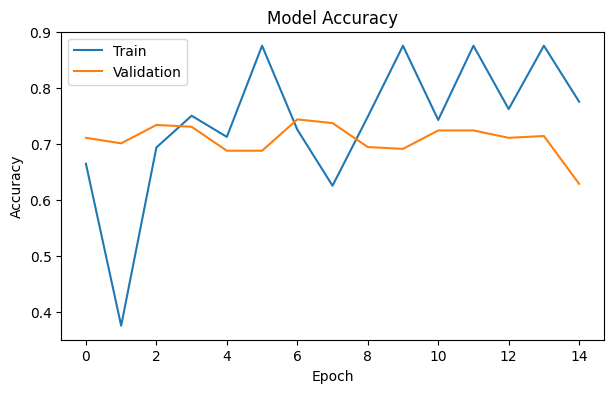

In [26]:
plt.figure(figsize=(7,4))
plt.plot(model_history.history['binary_accuracy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

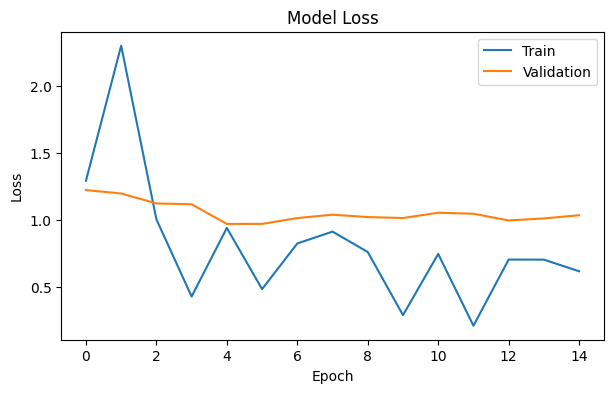

In [27]:
plt.figure(figsize=(7,4))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Acá se puede observar el tratamiento de las imágenes en cada convolución, creando filtros donde detecta formas básicas y complejas como bordes, texturas y formas

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


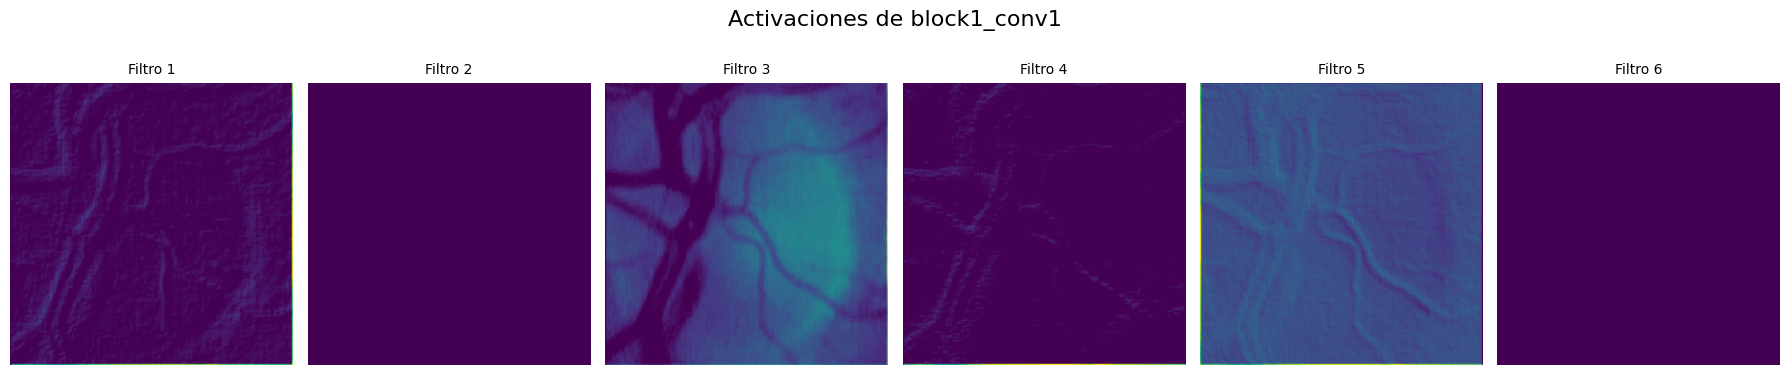

In [28]:
# 1. Cargar imagen aleatoria
img_path = df_train['Path'].iloc[0]
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# 2. Modelo intermedio
layer_name = 'block1_conv1'
# layer_name = 'block2_conv2'
# layer_name = 'block3_conv3'
# layer_name = 'block5_conv3'
intermediate_layer_model = Model(inputs=vgg16_model.input,
                                 outputs=vgg16_model.get_layer(layer_name).output)

# 3. Activaciones
feature_maps = intermediate_layer_model.predict(img_array)

# 4. Visualización en una sola fila
num_filters = 6
plt.figure(figsize=(3 * num_filters, 4))  # Ajusta el tamaño horizontal dinámicamente

for i in range(num_filters):
    plt.subplot(1, num_filters, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filtro {i+1}', fontsize=10)

plt.suptitle(f'Activaciones de {layer_name}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # deja espacio para el título
plt.show()


Encontramos el mejor umbral para la clasificación de las muestras


In [29]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Obtener probabilidades y etiquetas verdaderas
y_proba = vgg16_model.predict(test_generator).reshape(-1)
y_true = test_generator.classes

# Curvas de precisión y recall
precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

# Calcular F1 para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# Elegir umbral con mejor F1
best_index = np.argmax(f1_scores)
best_th = thresholds[best_index]
print(f"Mejor umbral: {best_th:.2f}")
print(f"F1 score en ese umbral: {f1_scores[best_index]:.3f}")

# Aplicar mejor umbral
y_pred = (y_proba > best_th).astype(int)


39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step
Mejor umbral: 0.01
F1 score en ese umbral: 0.436


Reporte de clasificación y Accuracy

In [30]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Reporte de clasificación:\n", classification_report(y_true, y_pred))

Accuracy: 0.40514469453376206
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.24      0.38       235
           1       0.28      0.92      0.43        76

    accuracy                           0.41       311
   macro avg       0.59      0.58      0.40       311
weighted avg       0.75      0.41      0.39       311



In [31]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 56, 179],
       [  6,  70]], dtype=int64)

Matriz de Confusión

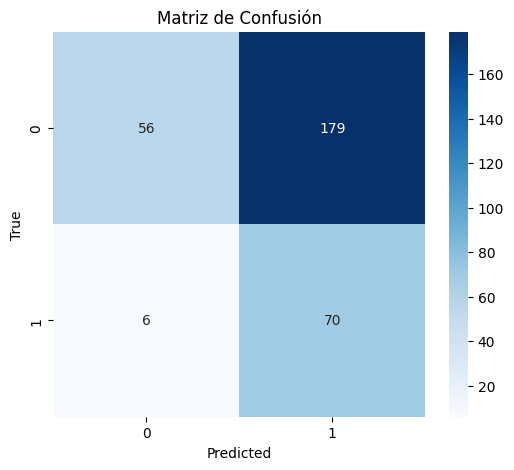

In [32]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

Curva ROC

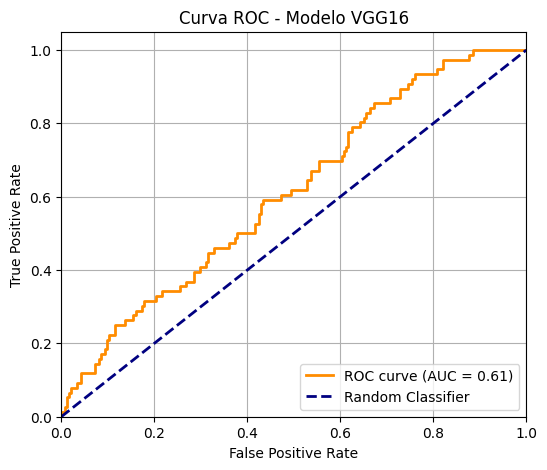

In [33]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo VGG16')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Accuracy: 0.40514469453376206
Sensitivity (Recall): 0.9210526315789473
Specificity: 0.23829787234042554
Precision (PPV): 0.28112449799196787
Negative Predictive Value (NPV): 0.9032258064516129
Dice Coefficient (F1): 0.4307692307692308


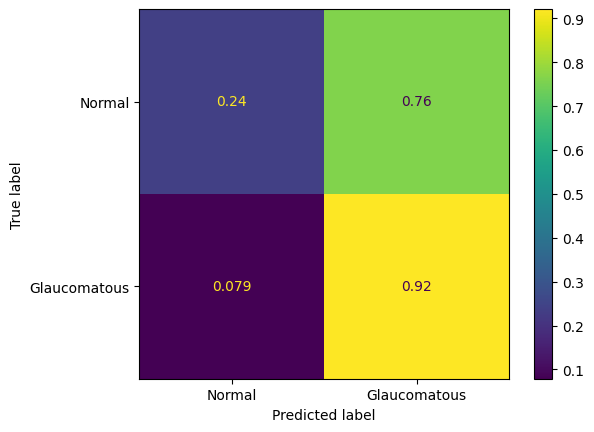

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix and metrics
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

sen = tp / (tp + fn)  # Sensitivity / Recall
sp = tn / (tn + fp)   # Specificity
acc = (tp + tn) / (tn + fp + fn + tp)  # Accuracy
ppv = tp / (tp + fp)  # Precision / PPV
npv = tn / (tn + fn)  # NPV
dsc = 2 * tp / (2 * tp + fp + fn)  # Dice / F1

print("Accuracy:", acc)
print("Sensitivity (Recall):", sen)
print("Specificity:", sp)
print("Precision (PPV):", ppv)
print("Negative Predictive Value (NPV):", npv)
print("Dice Coefficient (F1):", dsc)

# Confusion Matrix Plot
CATEGORIES = ["Normal", "Glaucomatous"]
cmd = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=CATEGORIES, normalize='true'
)
cmd.figure_.savefig('confusion_matrix.jpg', dpi=300)
